In [53]:
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster("./example_data/elevation.tiff")
dem = grid.read_raster("./example_data/elevation.tiff")

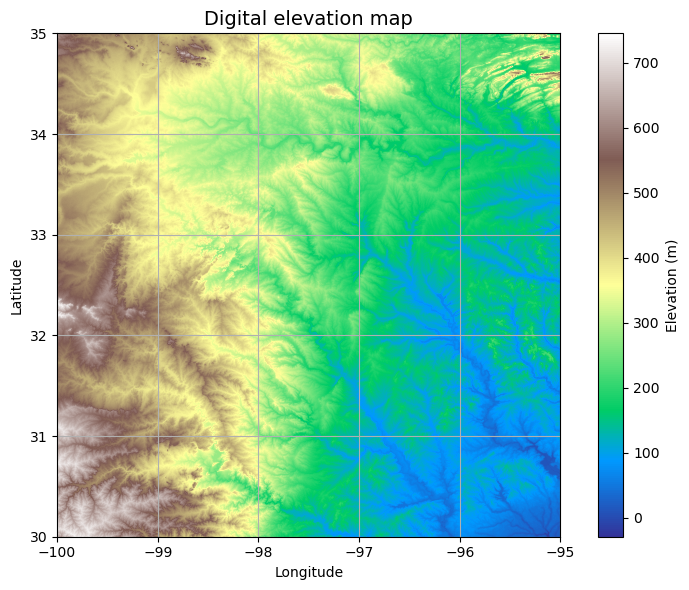

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap="terrain", zorder=1)
plt.colorbar(label="Elevation (m)")
plt.grid(zorder=0)
plt.title("Digital elevation map", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

In [55]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [56]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

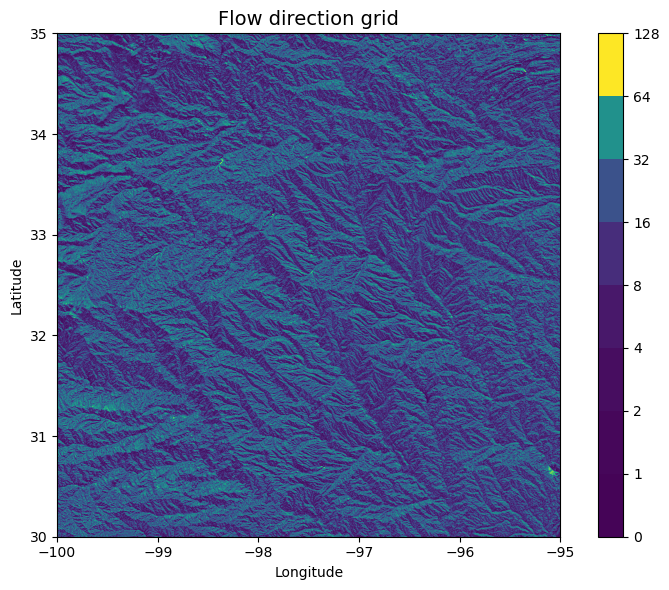

In [57]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap="viridis", zorder=2)
boundaries = [0] + sorted(list(dirmap))
plt.colorbar(boundaries=boundaries, values=sorted(dirmap))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flow direction grid", size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [58]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

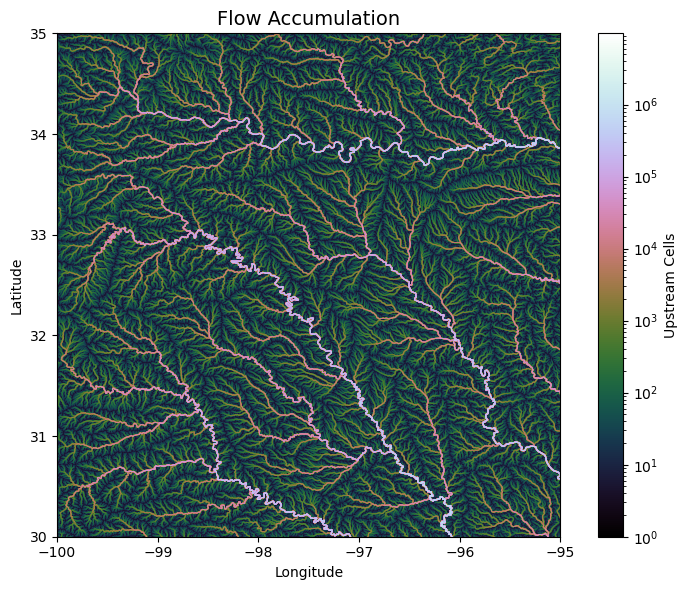

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells")
plt.title("Flow Accumulation", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

In [60]:
# Delineate a catchment
# ---------------------
# Specify pour point
# first: x, y = -97.294, 32.737
x, y = -95.86682, 31.72134

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(
    x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype="coordinate"
)

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

In [61]:
import geopandas as gpd
from shapely import geometry, ops


shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])
gdf = gpd.GeoDataFrame(geometry=[catchment_polygon])
gdf.to_file("./example_data/catchment2.shp")

Text(0.5, 1.0, 'Delineated Catchment')

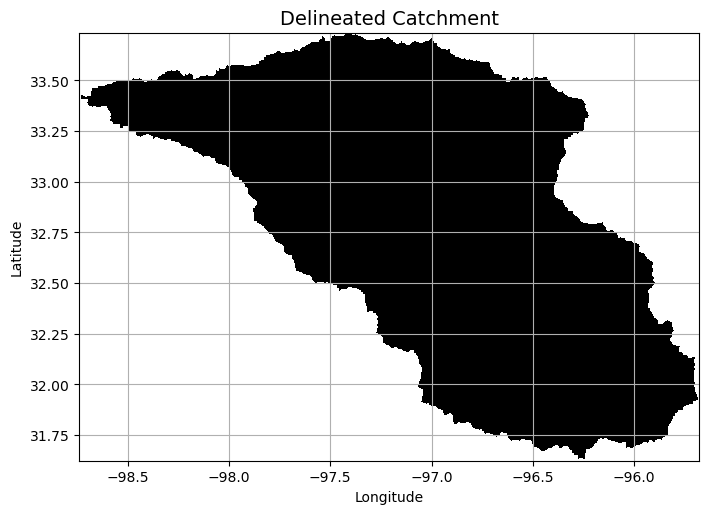

In [62]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.grid("on", zorder=0)
im = ax.imshow(
    np.where(clipped_catch, clipped_catch, np.nan),
    extent=grid.extent,
    zorder=1,
    cmap="Greys_r",
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Delineated Catchment", size=14)

In [63]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

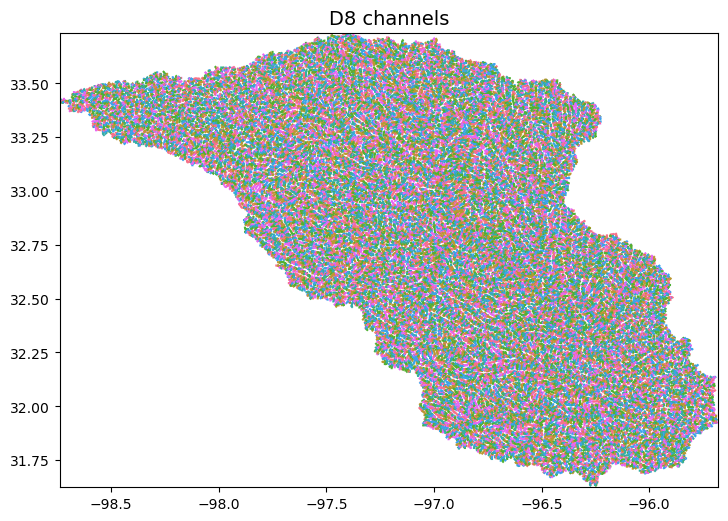

: 

In [64]:
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(8.5, 6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect("equal")

for branch in branches["features"]:
    line = np.asarray(branch["geometry"]["coordinates"])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title("D8 channels", size=14)

In [65]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(
    x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype="coordinate"
)

Text(0.5, 1.0, 'Flow Distance')

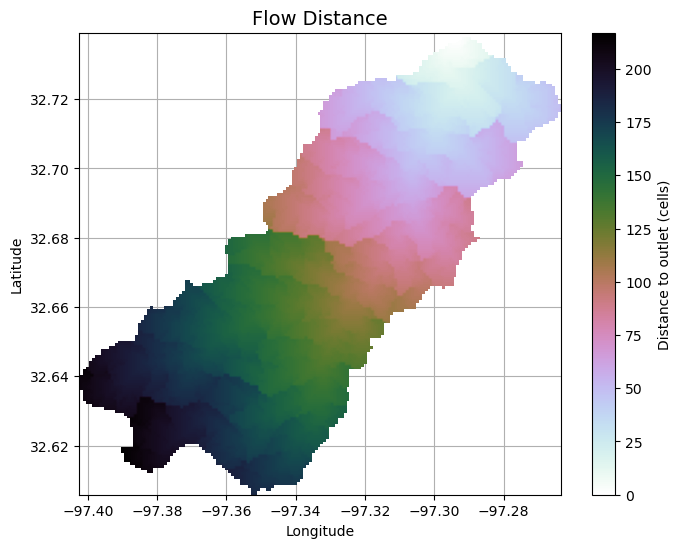

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2, cmap="cubehelix_r")
plt.colorbar(im, ax=ax, label="Distance to outlet (cells)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flow Distance", size=14)

In [ ]:
# Combine with land cover data
# ---------------------
terrain = grid.read_raster(
    "./example_data/impervious_area/impervious_area.tiff", window=grid.bbox, window_crs=grid.crs, nodata=0
)
# Reproject data to grid's coordinate reference system
projected_terrain = terrain.to_crs(grid.crs)
# View data in catchment's spatial extent
catchment_terrain = grid.view(projected_terrain, nodata=np.nan)

In [ ]:
# Convert catchment raster to vector and combine with soils shapefile
# ---------------------
# Read soils shapefile
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops

soils = gpd.read_file("./example_data/soils/soils.shp")
soil_id = "MUKEY"
# Convert catchment raster to vector geometry and find intersection
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])
soils = soils[soils.intersects(catchment_polygon)]
catchment_soils = gpd.GeoDataFrame(
    soils[soil_id], geometry=soils.intersection(catchment_polygon)
)
# Convert soil types to simple integer values
soil_types = np.unique(catchment_soils[soil_id])
soil_types = pd.Series(np.arange(soil_types.size), index=soil_types)
catchment_soils[soil_id] = catchment_soils[soil_id].map(soil_types)

Text(0.5, 1.0, 'Soil types (vector)')

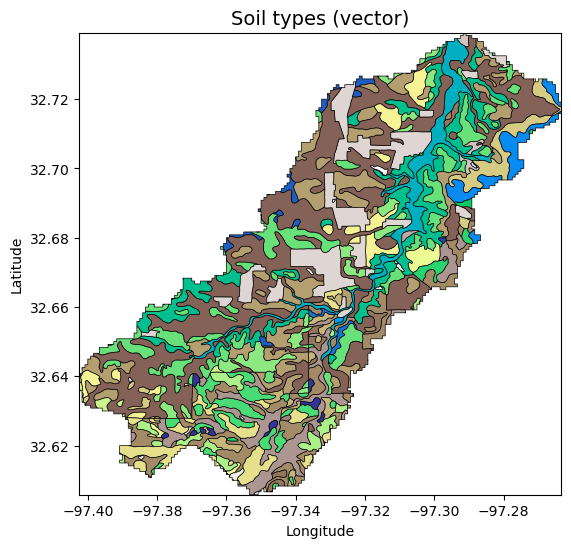

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
catchment_soils.plot(
    ax=ax,
    column=soil_id,
    categorical=True,
    cmap="terrain",
    linewidth=0.5,
    edgecolor="k",
    alpha=1,
    aspect="equal",
)
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_title("Soil types (vector)", size=14)

In [ ]:
soil_polygons = zip(catchment_soils.geometry.values, catchment_soils[soil_id].values)
soil_raster = grid.rasterize(soil_polygons, fill=np.nan)

Text(0.5, 1.0, 'Soil types (raster)')

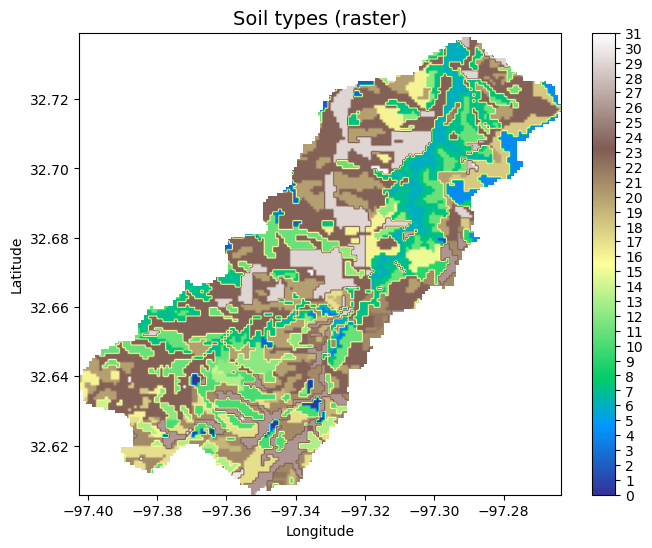

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(soil_raster, cmap="terrain", extent=grid.extent, zorder=1)
boundaries = np.unique(soil_raster[~np.isnan(soil_raster)]).astype(int)
plt.colorbar(ticks=boundaries)
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_title("Soil types (raster)", size=14)